## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
data = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = data['train']
test = data['test']
valid = data['validation']

In [ ]:
def inp_tweet(dat):
  tweet = [x['text'] for x in dat]
  labels = [x['label'] for x in dat]
  return tweet, labels

In [ ]:
tweet, labels = inp_tweet(train)

In [ ]:
#Example of the tweet and label
tweet[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
token = Tokenizer(num_words=15000, oov_token = '<UNK>')
token.fit_on_texts(tweet)

In [ ]:
token.texts_to_sequences([tweet[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

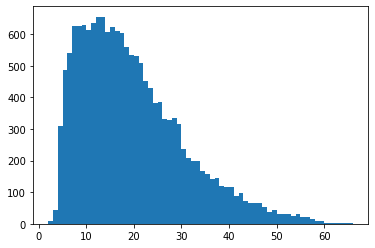

In [ ]:
length = [len(t.split(' ')) for t in tweet]
plt.hist(length, bins = len(set(length)))
plt.show()

In [ ]:
high = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_seq(token, tweet):
  seq = token.texts_to_sequences(tweet)
  pad = pad_sequences(seq, truncating='post', padding='post', maxlen=high)
  return pad

In [ ]:
pad_train_seq = get_seq(token, tweet)


In [ ]:
pad_train_seq

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

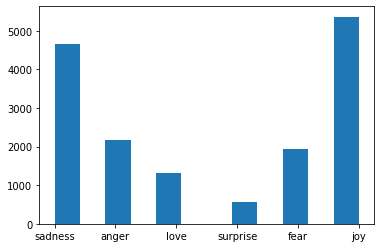

In [ ]:
#Number of tweets for each label
plt.hist(labels, bins=12)
plt.show()

In [ ]:
class_ind = dict((c, i) for i, c in enumerate(classes))
ind_class = dict((t, j) for j, t in class_ind.items())

In [ ]:
class_ind

{'anger': 3, 'fear': 0, 'joy': 5, 'love': 2, 'sadness': 4, 'surprise': 1}

In [ ]:
ind_class

{0: 'fear', 1: 'surprise', 2: 'love', 3: 'anger', 4: 'sadness', 5: 'joy'}

In [ ]:
name_id = lambda labels: np.array([class_ind.get(x) for x in labels])

In [ ]:
train_labels = name_id(labels)

In [ ]:
train_labels[0]

4

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(15000, 16, input_length=high),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweet, val_labels = inp_tweet(valid)
val_seq = get_seq(token, val_tweet)
val_labels = name_id(val_labels)

In [ ]:
val_tweet[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
val_mod = model.fit(
    pad_train_seq, train_labels,
    validation_data=[val_seq, val_labels],
    epochs=25,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/25
500/500 [==============================] - 40s 60ms/step - loss: 1.2864 - accuracy: 0.4963 - val_loss: 0.8040 - val_accuracy: 0.6950
Epoch 2/25
500/500 [==============================] - 28s 55ms/step - loss: 0.4229 - accuracy: 0.8632 - val_loss: 0.4654 - val_accuracy: 0.8465
Epoch 3/25
500/500 [==============================] - 28s 56ms/step - loss: 0.2112 - accuracy: 0.9338 - val_loss: 0.3950 - val_accuracy: 0.8640
Epoch 4/25
500/500 [==============================] - 28s 56ms/step - loss: 0.1424 - accuracy: 0.9542 - val_loss: 0.3738 - val_accuracy: 0.8800
Epoch 5/25
500/500 [==============================] - 28s 56ms/step - loss: 0.1080 - accuracy: 0.9667 - val_loss: 0.4119 - val_accuracy: 0.8785
Epoch 6/25
500/500 [==============================] - 28s 56ms/step - loss: 0.0904 - accuracy: 0.9732 - val_loss: 0.4457 - val_accuracy: 0.8830
Epoch 7/25
500/500 [==============================] - 28s 55ms/step - loss: 0.0789 - accuracy: 0.9755 - val_loss: 0.4127 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set



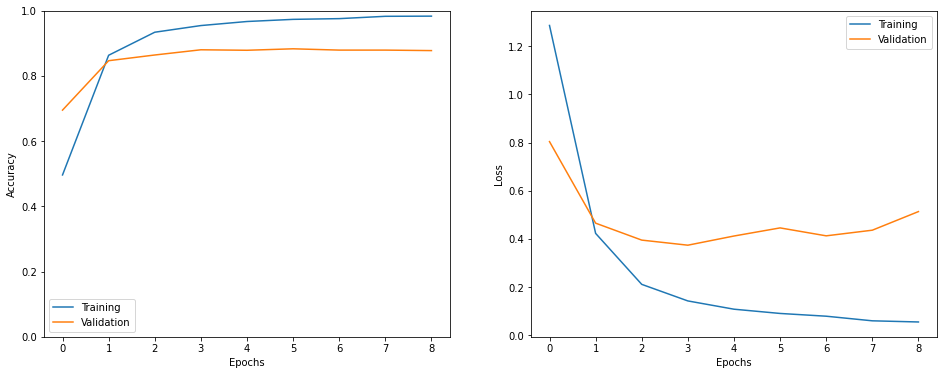

In [ ]:
show_history(val_mod)

In [ ]:
test_tweet, test_labels = inp_tweet(test)
test_seq = get_seq(token, test_tweet)
test_labels = name_id(test_labels)

In [ ]:
test_mod = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.5370 - accuracy: 0.8680


In [ ]:
pred = model.predict(np.expand_dims(test_seq[11], axis=0))[0]
pred_class = ind_class[np.argmax(pred).astype('uint8')]

print('Sentence: ', test_tweet[11])
print('Emotion: ', ind_class[test_labels[11]])
print('Predicted emotion: ', pred_class)


Sentence:  i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey
Emotion:  sadness
Predicted emotion:  sadness
